In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import Counter
from scipy.signal import argrelextrema
from scipy.special import factorial
import itertools

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_extended_kalman_filter_2 import HungarianExtendedKalmanFilter

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

# Load the seismogram

In [2]:
# Paths to your files
image_path = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\raw\UCC19540112Gal_E_0750_binary.jpg"

# Load image as grayscale and convert to float32
image_source = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
image_source = image_source.astype(np.float32) / 255.0  # Normalize to [0, 1]
image_source = image_source.max() - image_source  # Invert the image

# crop
# image_source = image_source[:, 1000:2000]
image_source = image_source[775:1090, 1000:2000]

# Confirm shapes
print("Image shape:", image_source.shape)   # (height, width)

Image shape: (315, 1000)


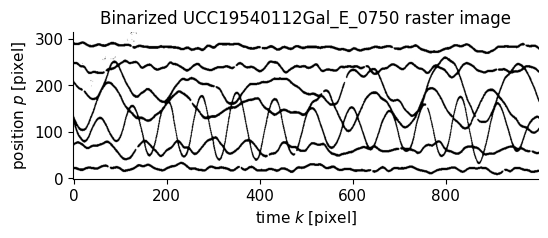

In [ ]:
# First figure: imshow
plt.figure(figsize=(12, 5))
plt.imshow(image_source.max()-image_source, cmap='gray', origin='lower')
plt.xlabel(r"time $k$ [pixel]")
plt.ylabel(r"position $p$ [pixel]")
plt.title("Binarized UCC19540112Gal_E_0750 raster image")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_binary.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Second figure: scatter-only pixel representation
# plt.figure(figsize=(12, 5))
# for k in range(len(gt[0])):
#     col = np.where(image[:, k] > 0.5)[0]
#     if len(col) > 0:
#         plt.scatter(k*np.ones_like(col), col, s=1, color='red', alpha=0.6)  
# plt.title("Pixel Discretization of Ground Truth Traces (scatter only)")
# plt.xlabel("k (time)")
# plt.ylabel("p (position)")
# plt.grid(True)
# plt.show()


## Get Region Of Interest

Threshold1: 300.4085693359375
Threshold2: 158.55607147216796


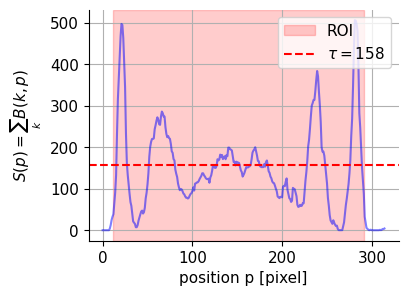

In [4]:
def get_roi(image, threshold = 100):
    """
    Extract the region of interest from an image based on row sum threshold.

    Parameters:
    - image (np.ndarray): 2D or 3D grayscale image array.
    - threshold (int): Minimum row sum to consider as part of the ROI.

    Returns:
    - roi (np.ndarray): Cropped image containing only the rows in the ROI.
    - start_row (int): Index of the first row included in the ROI.
    - end_row (int): Index of the last row (exclusive) in the ROI.
    """
    sum_rows = image.sum(axis=1)
    indices = np.where(sum_rows > threshold)[0]

    if len(indices) == 0:
        print("No rows exceed the threshold.")
        return image[0:1], 0, 1  # dummy ROI and bounds

    start_row = max(int(indices[0] - 0.01 * image.shape[0]), 0)
    end_row = min(int(indices[-1] + 0.01 * image.shape[0]), image.shape[0])

    roi = image[start_row:end_row]
    return roi, start_row, end_row

sum_rows = image_source.sum(axis=1)

plt.figure(figsize=(4, 3))
plt.plot(sum_rows, color='blue', alpha=0.5)
plt.xlabel("position p [pixel]")
plt.ylabel(r"$S(p) = \sum_k B(k, p)$")
plt.grid(True)

# Thresholds
k = 1.5
threshold1 = np.mean(sum_rows) + k * np.std(sum_rows)
print("Threshold1:", threshold1)

threshold2 = np.percentile(sum_rows, 65)
print("Threshold2:", threshold2)

# Get region of interest using one of the thresholds
image, start_row, end_row = get_roi(image_source, threshold=int(threshold2))

# Highlight ROI with vertical bars
plt.axvspan(start_row, end_row, color='red', alpha=0.2, label='ROI')
plt.axhline(y=threshold2, color='red', linestyle='--', label=r'$\tau = {}$'.format(int(threshold2)))
plt.legend()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"get_roi.pdf"), format="pdf", bbox_inches='tight', dpi=300)

plt.show()

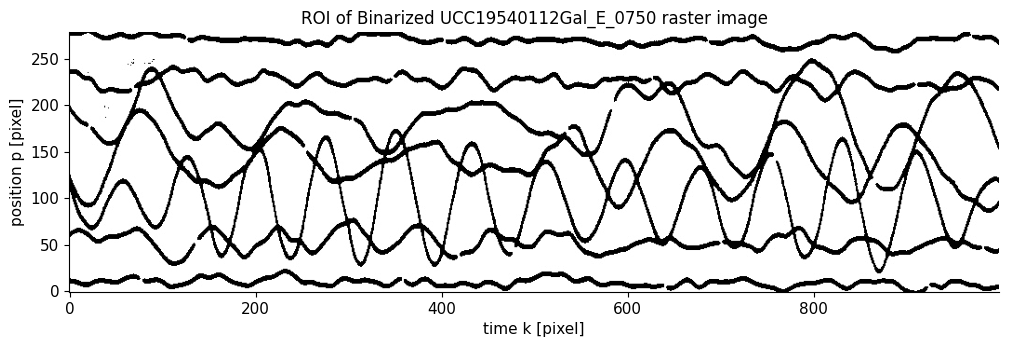

In [5]:
# First figure: imshow
plt.figure(figsize=(12, 5))
plt.imshow(image.max()-image, cmap='gray', origin='lower')
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.title("ROI of Binarized UCC19540112Gal_E_0750 raster image")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_binary_roi.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Get number of components and average thickness

In [ ]:
def count_components_and_avg_thickness(arr, threshold=0.5):
    """
    Counts the number of connected components where values are close to 1 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing binary values (0 for background, 1 for foreground).
    - threshold: Defines what is considered "foreground" (default: 0.5 for binary).

    Returns:
    - count: Number of connected components (foreground regions).
    - avg_thickness: Average thickness (length) of those components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] > threshold:  # Found a new foreground component
            count += 1
            start = i
            while i < n and arr[i] > threshold:
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(image.shape[1]):
    n, t = count_components_and_avg_thickness(image[:, i])
    N_components.append(n)
    thickness.append(t)

# compute the average thickness and number of components for the image by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 0.9]
thickness = thickness[thickness > 0.9]

def most_common_component_count(N_components):
    """
    Returns the most frequently occurring value in the list of component counts.
    If there's a tie, returns the smallest one.
    """
    counter = Counter(N_components)
    print(counter)
    most_common = counter.most_common(1)[0][0]  # (value, frequency)
    return most_common

# Example usage
most_N_components = most_common_component_count(N_components)
print("Most common component count:", most_N_components)

median_N_components = int(np.round(np.median(N_components)))
print(f"Median number of components: {median_N_components}")
avg_N_components = 44 #int(np.round(np.mean(N_components)))
avg_thickness = int(np.round(np.mean(thickness)))
print(f"Average number of components: {avg_N_components} VS true value is 7")
print(f"Average thickness: {avg_thickness}")

Counter({43: 3359, 42: 2173, 44: 1996, 41: 742, 40: 195, 45: 124, 39: 49, 38: 30, 46: 16, 37: 16, 36: 14, 35: 8, 32: 6, 34: 6, 1: 5, 31: 4, 22: 3, 29: 3, 3: 3, 5: 3, 10: 3, 13: 3, 47: 3, 33: 3, 26: 2, 21: 2, 14: 2, 19: 2, 28: 2, 4: 2, 7: 1, 15: 1, 25: 1, 2: 1, 20: 1, 30: 1, 17: 1, 8: 1, 16: 1, 18: 1, 23: 1, 27: 1, 24: 1})
Most common component count: 43
Median number of components: 43
Average number of components: 44 VS true value is 7
Average thickness: 6


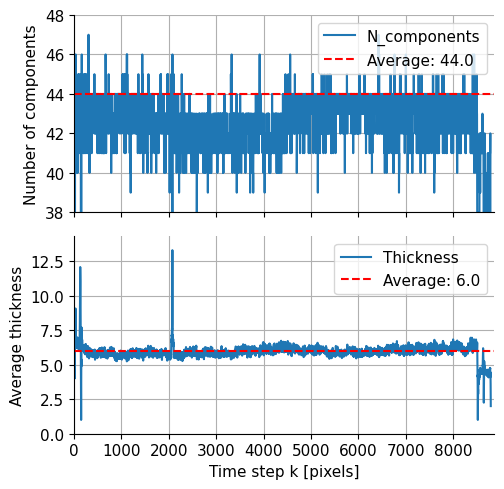

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

# --- Top subplot: Number of components ---
ax1.plot(N_components, label="N_components")
ax1.axhline(y=avg_N_components, color='r', linestyle='--', label=f"Average: {avg_N_components:.1f}")
ax1.set_xlim(0, image.shape[1])
ax1.set_ylim(38, 48)
ax1.set_ylabel("Number of components")
ax1.legend()
ax1.grid(True)

# --- Bottom subplot: Average thickness ---
ax2.plot(thickness, label="Thickness")
ax2.axhline(y=avg_thickness, color='r', linestyle='--', label=f"Average: {avg_thickness:.1f}")
ax2.set_xlim(0, image.shape[1])
ax2.set_ylim(np.min(thickness)-1, np.max(thickness)+1)
ax2.set_xlabel("Time step k [pixels]")
ax2.set_ylabel("Average thickness")
ax2.legend()
ax2.grid(True)

# Tight layout for aesthetics
plt.tight_layout()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"N_com_thickness.pdf"), format="pdf", bbox_inches='tight', dpi=300)
plt.show()

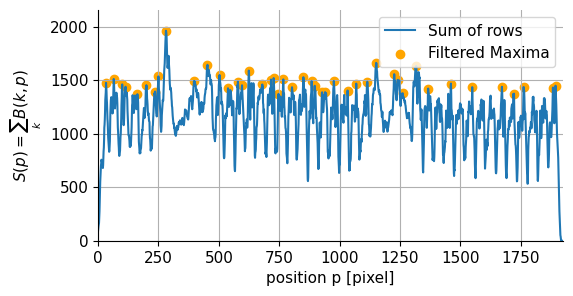

[  33   65  100  114  163  200  236  250  281  397  453  503  538  579
  596  624  680  716  727  747  767  803  850  884  897  928  940  976
 1033 1069 1115 1151 1226 1241 1261 1317 1367 1461 1549 1672 1722 1762
 1883 1894]
Filtered array: [32 35 14 49 37 36 14 31 56 50 35 41 17 28 56 36 11 20 20 36 47 34 13 31
 12 36 57 36 46 36 75 15 20 56 50 88 50 40 11]
Mean without outliers: 37


In [ ]:

# Step 1: Sum the rows
sum_rows = np.sum(image, axis=1)
plt

# Step 2: Find local maxima
max_indices = argrelextrema(sum_rows, np.greater, order=10)[0]

# Step 3: Sort maxima by peak height (descending)
sorted_max = max_indices[np.argsort(sum_rows[max_indices])[::-1]]

# Step 4: Keep only top N
top_max = sorted_max[:avg_N_components]

# Step 5: Filter out those lower than half the max peak value
peak_values = sum_rows[top_max]
max_peak_value = np.max(peak_values)
threshold_value = 0.5 * max_peak_value

filtered_max = top_max[peak_values >= threshold_value]

# Step 6: Plot
plt.figure(figsize=(6, 3))
plt.plot(sum_rows, label="Sum of rows")
plt.scatter(filtered_max, sum_rows[filtered_max], color='orange', label="Filtered Maxima")
plt.xlim(0, image.shape[0])
plt.ylim(0, np.max(sum_rows) + 0.1 * np.max(sum_rows))
plt.xlabel("position p [pixel]")
plt.ylabel(r"$S(p) = \sum_k B(k, p)$")
plt.grid(True)

plt.legend()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"filtered_max.pdf"), format="pdf", bbox_inches='tight', dpi=300)
plt.show()
# print sorted filtered max
print(np.sort(filtered_max))
arr = np.diff(np.sort(filtered_max))

# Compute IQR bounds
q1 = np.percentile(arr, 25)
q3 = np.percentile(arr, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered = arr[(arr >= lower_bound) & (arr <= upper_bound)]

# Compute the mean
mean_val = np.mean(filtered)

print("Filtered array:", filtered)
print("Mean without outliers:", int(1+np.round(mean_val)))

Average spacing between meanlines: 34.71052631578947


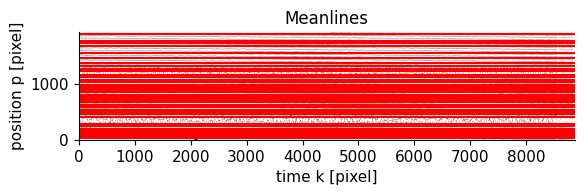

In [ ]:
# The meanlines are the num_components rows with the minimum sum

def mean_ignoring_outliers_std(arr, k=2):
    arr = np.array(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    filtered = arr[np.abs(arr - mean) <= k * std]
    return np.mean(filtered)

meanlines = np.sort(filtered_max[:avg_N_components])
spaces = np.diff(meanlines)
spacing = mean_ignoring_outliers_std(spaces, k=1.5)

print("Average spacing between meanlines:", spacing)

plt.imshow(image.max() - image, cmap='gray', origin='lower')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_meanlines.jpg"), bbox_inches='tight', dpi=300)
plt.show()

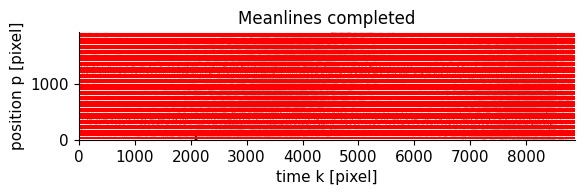

In [ ]:
meanlines = np.linspace(meanlines[0], meanlines[-1], avg_N_components)

plt.imshow(image.max() - image, cmap='gray', origin='lower')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines completed")
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_all_meanlines.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Extract the curves ($\omega$ constant)

In [ ]:
def function_f(x, dt):
    """ Non-linear state transition function for a sine-like model."""
    x_next =np.zeros_like(x, dtype=np.float64)
    x_next[0] = x[0]
    x_next[1] = x[1]
    x_next[2] = x[2] + dt * x[1]
    return x_next

def function_h(x, dt):
    """ Non-linear observation function for a sine-like model."""
    y = x[0] * np.sin(x[2])
    return y

def build_A_matrix(x, dt):
    """Build state linearized transition matrix A for a sine-like model."""
    A = np.eye(3, dtype=np.float64)
    A[2, 1] = dt
    return A

def build_H_matrix(x, dt):
    """Build observation matrix H for a sine-like model."""
    H = np.array([[np.sin(x[2]), 0, x[0]*np.cos(x[2])]], dtype=np.float64)
    return H

def build_Q_matrix(dt, sigma_a, sigma_w):
    """
    Build process noise covariance matrix Q for the state [p, p_dot, omega, b].

    - q: spectral density of white acceleration noise (for [p, p_dot] block)
    - sigma_w: variance of frequency noise (for omega random walk)
    - sigma_b: variance of offset noise (for b random walk)
    """
    Q = np.zeros((3, 3), dtype=np.float64)

    # Correct continuous white-acceleration model for [p, p_dot]
    Q[0, 0] = dt * sigma_a**2
    Q[1, 1] = dt * sigma_w**2
    Q[1, 2] = dt**2/2 * sigma_w**2
    Q[2, 1] = dt**2/2 * sigma_w**2
    Q[2, 2] = dt**3/3 * sigma_w**2

    return Q

def build_P_matrix(num_traces, sigma_a_0, sigma_omega_0, sigma_phi_0, dt):
    """Build initial state covariance matrix P with increasing uncertainty."""
    P_patern = np.array([[sigma_a_0**2, 0, 0],
                        [0, sigma_omega_0**2, 0],
                        [0, 0, sigma_phi_0**2,]])
    P = np.array([np.copy(P_patern) for _ in range(num_traces)]) * dt
    return P

In [ ]:
Dt_list = [0.007] # [0.007/2]
sigma_a_list = [0.5, 0.7, 1, 1.2]
sigma_omega_list = [0.5, 0.7, 1, 1.2]
sigma_z_list = [1]

a_0 = 20
omega_0 = np.pi/2
phi_0 = 0
a_0_list = [a_0]
omega_0_list = [omega_0]
phi_0_list = [phi_0]

sigma_a_0_list = [1]
sigma_omega_0_list = [1]
sigma_phi_0_list = [5]

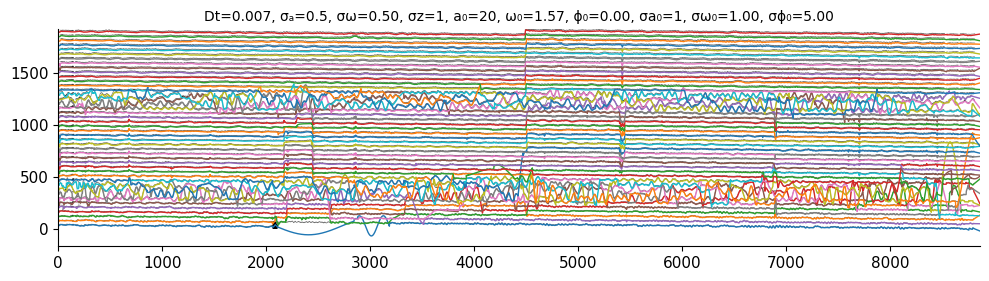

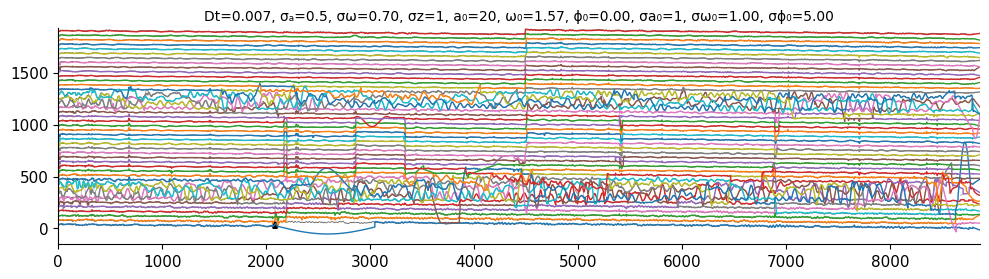

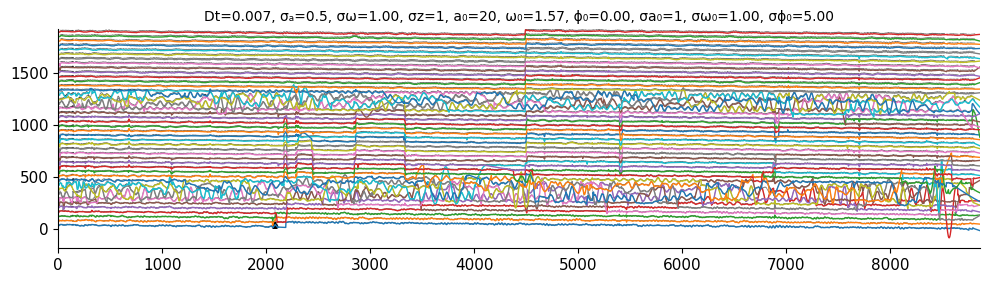

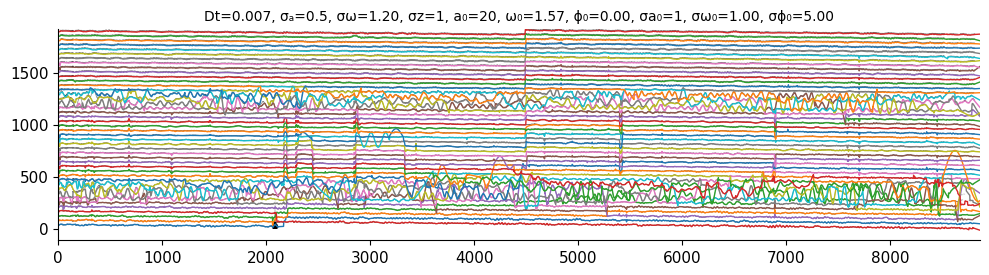

KeyboardInterrupt: 

In [ ]:
# Cartesian product of all combinations (warning: very large if fully used)
# param_combinations = [(0.007, 0.1, 0.1, 0.1, a_0, omega_0, phi_0, 1, 5, 1),
#                       (0.007, 0.1, 0.1,   1, a_0, omega_0, phi_0, 5, 5, 1),
#                       (0.007, 0.1,   1,   1, a_0, omega_0, phi_0, 1, 1, 1),
#                       (0.007,   1,   1,   1, a_0, omega_0, phi_0, 1, 1, 5),
#                       (0.007,   1,   1,   1, a_0, omega_0, phi_0, 1, 5, 5)
# ]

param_combinations = [(0.007,   0.7,   0.7,   1, a_0, omega_0, phi_0, 1, 1, 5)]

param_combinations = itertools.product(
        Dt_list, sigma_a_list, sigma_omega_list, sigma_z_list,
        a_0_list, omega_0_list, phi_0_list,
        sigma_a_0_list, sigma_omega_0_list, sigma_phi_0_list
    )

# Loop through a small number for illustration (adjust as needed)
for idx, (Dt, sigma_a, sigma_omega, sigma_z,
          a_0, omega_0, phi_0,
          sigma_a_0, sigma_omega_0, sigma_phi_0) in enumerate(param_combinations):
    Q = build_Q_matrix(Dt, sigma_a, sigma_omega)
    P_0 = build_P_matrix(avg_N_components, sigma_a_0, sigma_omega_0, sigma_phi_0, Dt)
    R = np.array([[sigma_z**2]], dtype=np.float64)
    HEKF = HungarianExtendedKalmanFilter(build_H_matrix, Q, R, Dt, function_f, function_h, build_A_matrix)

    X_0 = np.zeros((avg_N_components, Q.shape[-1]))
    X_0[:, 0] = a_0
    X_0[:, 1] = omega_0
    X_0[:, 2] = phi_0

    X_batch_pred, P_batch_pred = HEKF.process_sequence(image[np.newaxis][np.newaxis], X_0[np.newaxis], P_0[np.newaxis], meanlines, step=1)

    pred_positions = (X_batch_pred[:, :, :, 0] * np.sin(X_batch_pred[:, :, :, 2]))[0]
    for p in range(len(meanlines)):
        pred_positions[:, p] += meanlines[p]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 20))
    ax.imshow(image.max() - image, cmap='gray', origin='lower')
    t_steps = np.arange(0, image.shape[-1])
    for j in range(pred_positions.shape[1]):
        ax.plot(t_steps, pred_positions[:, j], linewidth=1)

    ax.set_title(
        f"Dt={Dt}, σₐ={sigma_a}, σω={sigma_omega:.2f}, σz={sigma_z}, "
        f"a₀={a_0}, ω₀={omega_0:.2f}, ϕ₀={phi_0:.2f}, "
        f"σa₀={sigma_a_0}, σω₀={sigma_omega_0:.2f}, σϕ₀={sigma_phi_0:.2f}",
        fontsize=10
    )
    plt.tight_layout()
    plt.grid(False)
    plt.show()
    plt.close(fig)
# fig.tight_layout()
# # Ensure the output folder exists
# output_folder_path = os.path.join(os.getcwd(), "output")
# os.makedirs(output_folder_path, exist_ok=True)

# # Save the figure
# fig.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_processed_w_cst.jpg"), bbox_inches='tight', dpi=300)

# T = pred_positions.shape[0]
# t = np.arange(T)
# fig, axes = plt.subplots(2, 1, figsize=(24, 10), sharex=True)

# labels = [r'$\dot{p}$', r'$\omega$']

# for l in range(2):
#     for j in range(avg_N_components):
#         pred = X_batch_pred[0, :, :, l+1]
#         std_pred = np.sqrt(P_batch_pred[0, :, :, l+1, l+1])

#         axes[l].plot(t, pred[:, j], label=f'Trace {j+1}')
#         axes[l].fill_between(t,
#                             pred[:, j] - std_pred[:, j],
#                             pred[:, j] + std_pred[:, j],
#                             alpha=0.3)

#     axes[l].set_xlim(0, T)
#     # axes[l].legend(markerscale=5)
#     axes[l].set_ylabel(labels[l])
# axes[-1].set_xlabel('Time step')